vqa
Question: Is sheet music?
Answer: <RET> Sorry, I cannot determine the answer as there is not enough information. <RET>


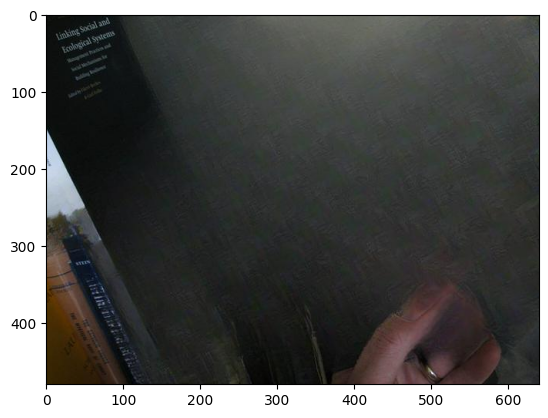

In [9]:
import json
from matplotlib import pyplot as plt

segsub_sample_data = json.load(open('../data/segsub_data_labelling_sample.json'))
segsub_directory = "../data/segsub_images/"

for idx in range(len(segsub_sample_data)):
    sample = segsub_sample_data[idx]
    if 'label' in sample or sample['dataset'] == 'webqa':
        continue
    question = sample["conversations"][0]["value"].split("\nQ: ")[-1]
    print(sample['dataset'])
    print(f"Question: {question}")
    answer = sample["conversations"][1]["value"]
    print(f"Answer: {answer}")
    for img_path in sample["image"]:
        # if img_path is int we skip for now
        if isinstance(img_path, int):
            break
        else:
            path = f"{segsub_directory}/{img_path}"
        plt.imshow(plt.imread(path))
    break


Showing batch 25 of 25


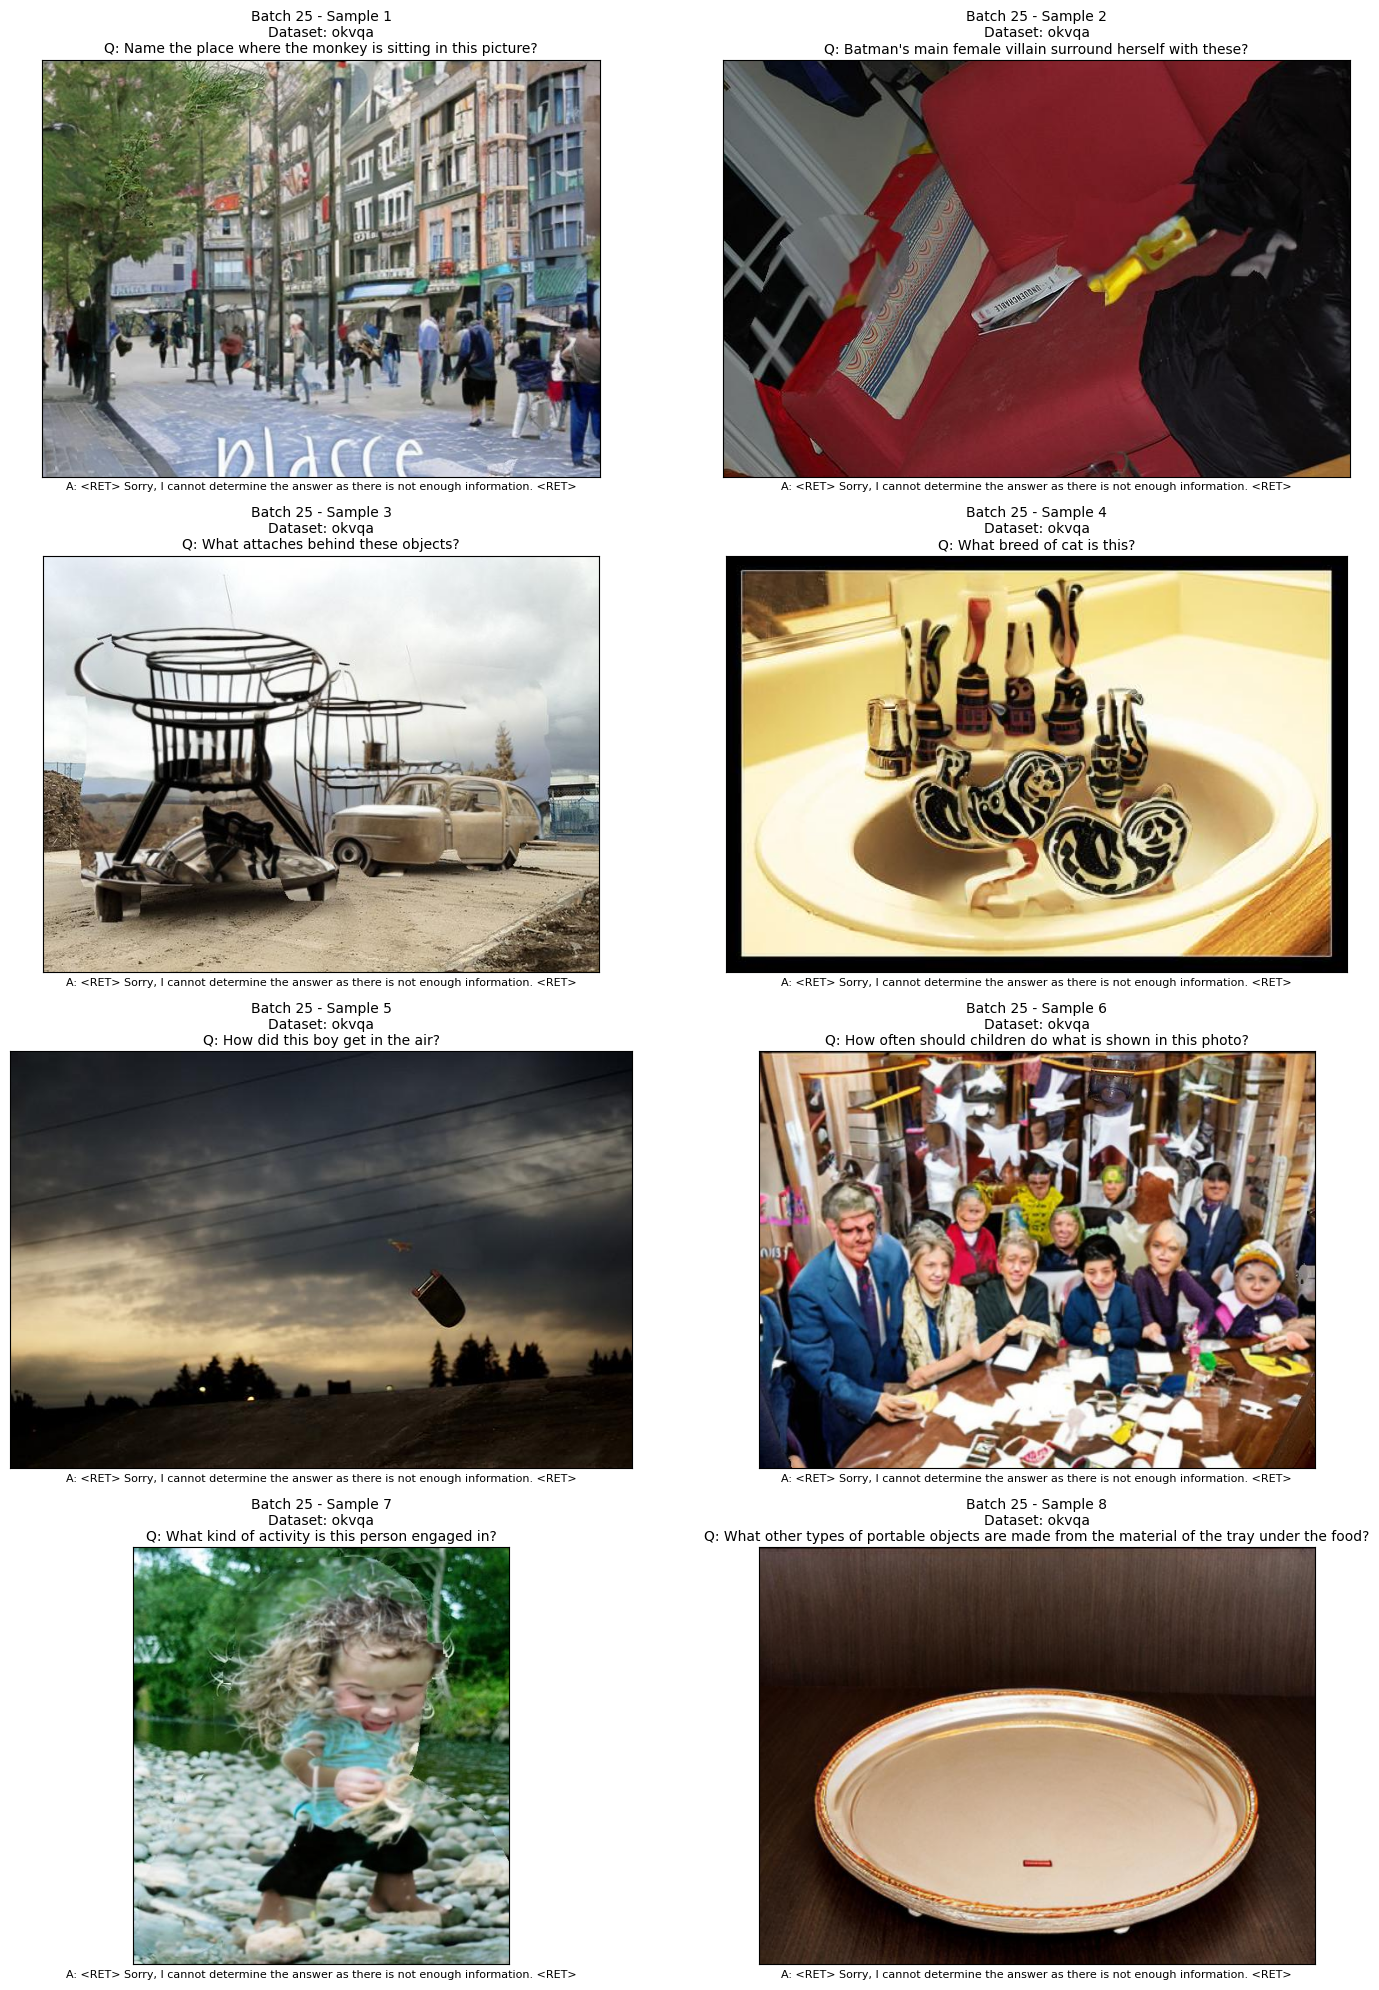

In [21]:
import json
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output

def visualize_dataset_batch(data, img_directory, batch_size=4, figsize=(15, 5)):
    """
    Visualizes a batch of images with their corresponding questions and answers,
    clearing previous batches before displaying new ones in Jupyter notebook.
    
    Args:
        data: List of dataset samples
        img_directory: Base directory for images
        batch_size: Number of samples to display in one batch
        figsize: Base figure size (will be adjusted based on batch size)
    """
    valid_samples = [
        sample for sample in data 
        if 'label' not in sample 
        and sample['dataset'] != 'webqa'
        and any(not isinstance(img, int) for img in sample['image'])
    ]
    
    for batch_start in range(0, len(valid_samples), batch_size):
        # Clear the current cell output
        clear_output(wait=True)
        
        batch = valid_samples[batch_start:batch_start + batch_size]
        n_samples = len(batch)
        
        # Calculate grid dimensions
        n_cols = min(2, n_samples)
        n_rows = math.ceil(n_samples / n_cols)
        
        # Create new figure
        fig = plt.figure(figsize=(figsize[0], figsize[1] * n_rows))
        
        for idx, sample in enumerate(batch):
            # Create subplot with extra space for text
            plt.subplot(n_rows, n_cols, idx + 1)
            
            # Get question and answer
            question = sample["conversations"][0]["value"].split("\nQ: ")[-1]
            answer = sample["conversations"][1]["value"]
            
            # Display first valid image
            for img_path in sample["image"]:
                if not isinstance(img_path, int):
                    path = f"{img_directory}/{img_path}"
                    plt.imshow(plt.imread(path))
                    break
            
            # Remove axes ticks
            plt.xticks([])
            plt.yticks([])
            
            # Add question and answer as title and caption
            plt.title(f"Batch {batch_start//batch_size + 1} - Sample {idx + 1}\n"
                     f"Dataset: {sample['dataset']}\nQ: {question}", 
                     fontsize=10, wrap=True)
            plt.xlabel(f"A: {answer}", fontsize=8, wrap=True)
        
        # Adjust layout to prevent overlap
        plt.tight_layout(h_pad=1.0, w_pad=1.0)
        
        # Show batch progress
        total_batches = math.ceil(len(valid_samples) / batch_size)
        current_batch = batch_start//batch_size + 1
        print(f"\nShowing batch {current_batch} of {total_batches}")
        
        # Display the current batch
        plt.show()
        
        # Optional: Add a prompt to continue
        if batch_start + batch_size < len(valid_samples):
            inp = input("Press Enter to see next batch or enter comma separated indexes to mark a wrong label for those indexes. `x` to exit")
            if inp == 'x':
                return
            # Flag incorrect samples for the batch
            flagged_idxs = []
            if len(inp) > 0:
                # Input will be 1-indexed
                flagged_idxs = [int(n) - 1 for n in inp.split(',')]
                print(flagged_idxs)
            # Go through each image in the batch and flag it
            for k in range(batch_size):
                curr_idx = batch_start + k
                valid_samples[curr_idx]['label'] = True
                if k in flagged_idxs:
                    valid_samples[curr_idx]['label'] = False
            # Write the labels back
            with open('../data/segsub_data_labelled.json', 'w') as f:
                f.write(json.dumps(valid_samples, indent=4))
            plt.close('all')  # Close the current figure before next batch

# Example usage:
segsub_sample_data = json.load(open('../data/segsub_data_labelling_sample.json'))
segsub_directory = "../data/segsub_images/"

visualize_dataset_batch(segsub_sample_data, segsub_directory, batch_size=8)